In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier

import os
import sys
# sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append('/usr/lib/python3.7/site-packages/')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


In [3]:
seed = 12

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes, title, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = confusion_matrix(y_true, y_pred, labels=classes)
    
    fig, ax = plt.subplots(figsize=(20, 17))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_ylim(len(classes)-0.5, -0.5)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def find_data(data_dir):
    tensors_path, labels_path = '', ''
    for dirpath, dirnames, filenames in os.walk(data_dir):
        for f in filenames:
            if f == 'metadata.tsv':
                labels_path = os.path.join(dirpath, f)
            elif f == 'tensors.tsv':
                tensors_path = os.path.join(dirpath, f)
    if not (tensors_path and labels_path):
        raise RuntimeError(f'Could not find required files!')
    return tensors_path, labels_path
    

def load_part_data(data_dir):
    X_path, y_path = find_data(data_dir)
    y = pd.read_csv(y_path, sep=':', encoding='utf-8', header=None).rename(columns={0:'job', 1:'name'})
    X = pd.read_csv(X_path, sep='\t', encoding='utf-8', header=None)
    return X, y


def load_data(data_dir, validation=True):
    X_train, y_train = load_part_data(os.path.join(data_dir, 'train'))
    X_valid, y_valid = load_part_data(os.path.join(data_dir, 'validation'))
    X_test, y_test = load_part_data(os.path.join(data_dir, 'test'))
    if not validation: 
        X_train = X_train.append(X_valid, ignore_index=True)
        y_train = y_train.append(y_valid, ignore_index=True)
        return X_train, y_train, X_test, y_test
    
    return X_train, y_train, X_test, y_test, X_valid, y_valid

In [5]:
X_train, y_train, X_test, y_test = load_data('../projections/onet/elmo_corpus_sentence', validation=False)
len(X_train), len(y_train), len(X_test), len(y_test)

(865, 865, 92, 92)

In [6]:
y_train.head()

,job,name
0,politycy,Zbigniew Bujak
1,politycy,Władysław Frasyniuk
2,politycy,Barbara Labuda
3,politycy,Józef Pinior
4,politycy,Donald Tusk


In [7]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.262281,-0.096596,0.000751,-0.242584,-0.090447,0.496533,0.612335,-0.666502,-0.437810,0.675194,...,-0.564428,0.714241,-0.399184,-0.440712,0.156842,-0.366483,0.282918,0.952838,-0.021817,-0.877401
1,0.200376,-0.138684,0.055646,-0.210187,-0.073032,0.400059,0.561931,-0.646101,-0.475706,0.615342,...,-0.574303,0.779437,-0.440973,-0.333877,0.025872,-0.404412,0.157701,0.943590,-0.085179,-0.858896
2,0.282218,-0.109399,0.008973,-0.229405,-0.062581,0.444397,0.645155,-0.634261,-0.476765,0.721822,...,-0.411739,0.696788,-0.355700,-0.400000,0.129261,-0.321320,0.138312,0.970497,-0.053732,-0.954584
3,0.218149,-0.373843,0.502904,-0.604541,-0.083107,0.172496,0.712170,-0.566690,-0.543743,0.427022,...,-0.735048,0.856665,-0.472014,-0.049975,0.163640,-0.318494,-0.672726,1.319686,-0.841021,-0.625741
4,0.033528,-0.217472,0.365095,-0.154890,-0.025706,0.222634,0.554974,-0.417413,-0.400015,0.456431,...,-0.667173,0.597452,-0.470039,-0.131182,0.124743,-0.303291,0.315243,0.809132,-0.483802,-0.629464


In [8]:
names_train, names_test = y_train['name'], y_test['name']
y_train, y_test = y_train['job'], y_test['job']

In [9]:
model = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=seed)
# model = XGBClassifier(learning_rate=0.01, n_estimators=300, n_jobs=-1, random_state=seed)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)

In [10]:
preds = model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {round(accuracy*100, 2)}%')

Accuracy: 53.26%


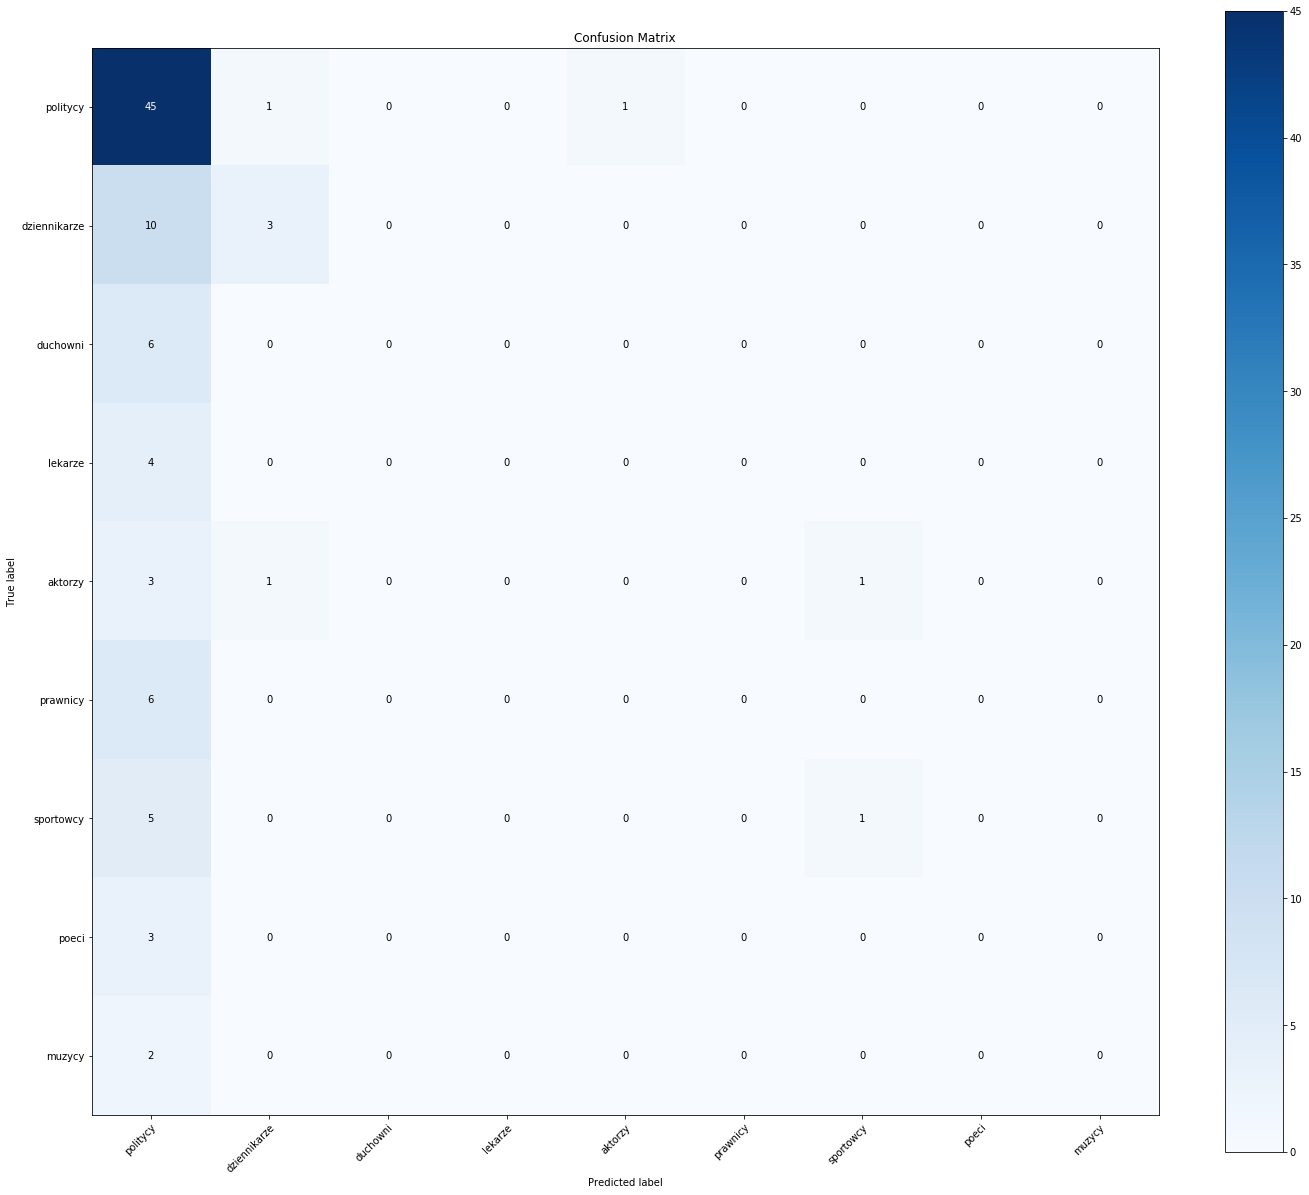

In [11]:
classes = y_test.unique()
plot_confusion_matrix(y_test, preds, classes, 'Confusion Matrix')

In [12]:
model = XGBClassifier(learning_rate=0.01, n_estimators=300, n_jobs=-1, random_state=seed)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=12,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [13]:
preds = model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy: {round(accuracy*100, 2)}%')

Accuracy: 52.17%


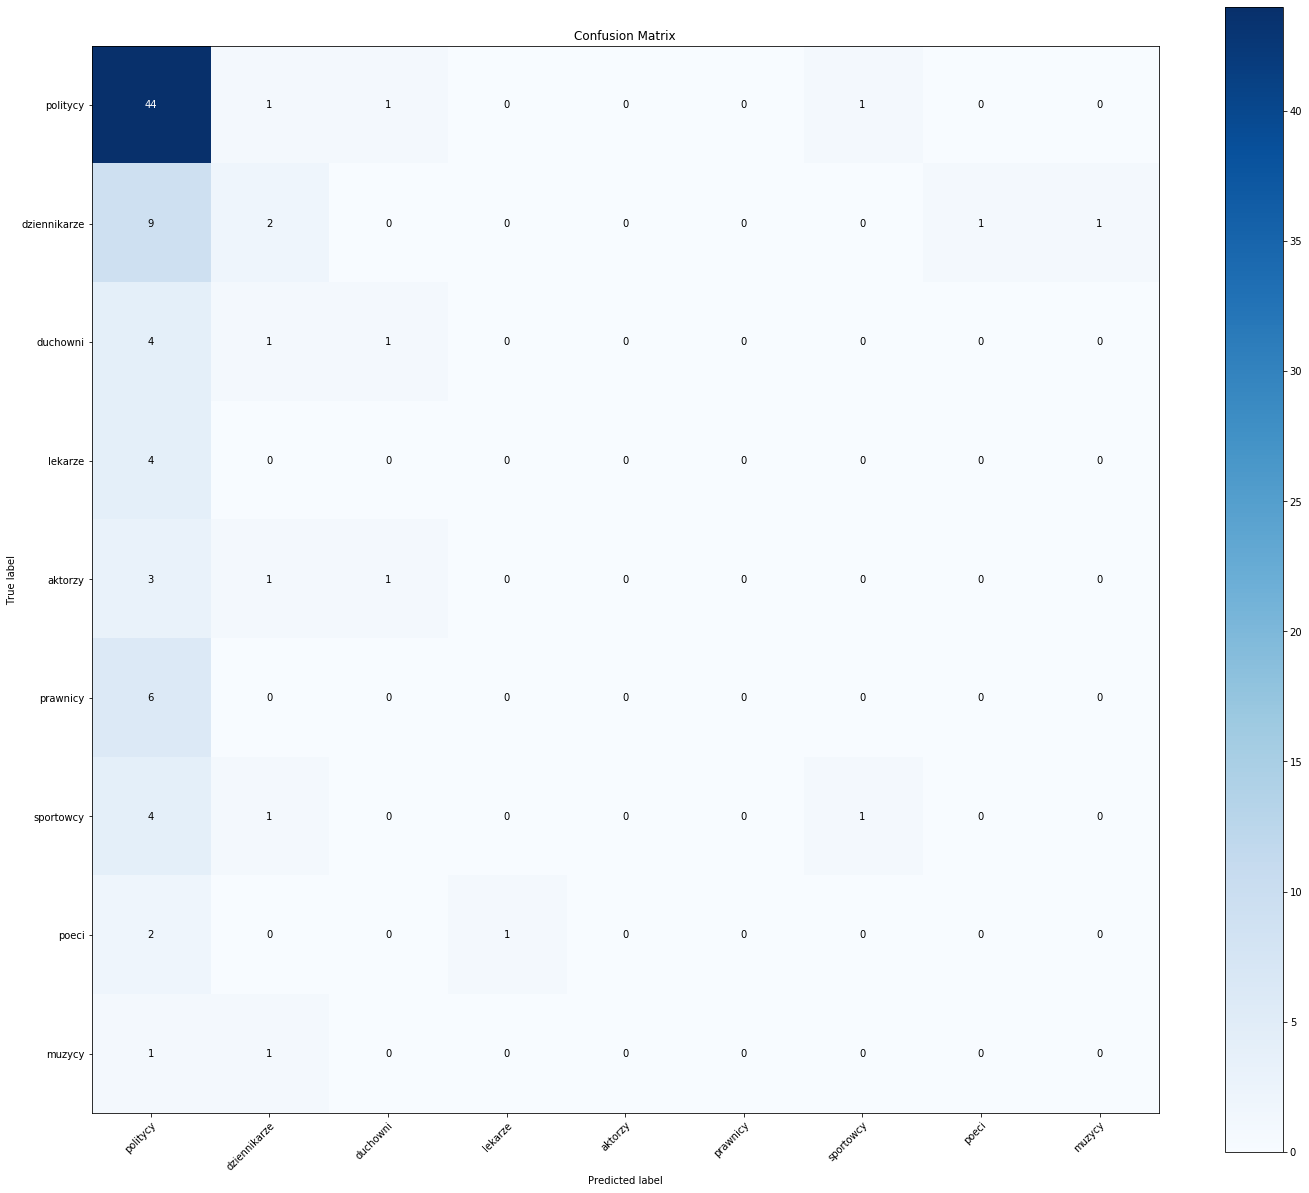

In [14]:
classes = y_test.unique()
plot_confusion_matrix(y_test, preds, classes, 'Confusion Matrix')

In [15]:
X_train, y_train, X_test, y_test, X_valid, y_valid = load_data('../projections/onet/elmo_corpus_sentence', validation=True)
len(X_train), len(y_train), len(X_test), len(y_test), len(X_valid), len(y_valid)

(774, 774, 92, 92, 91, 91)

In [16]:
names_train, names_test, names_valid = y_train['name'], y_test['name'], y_valid['name']
y_train, y_test, y_valid = y_train['job'], y_test['job'], y_valid['job']

In [17]:
classes = y_train.unique()

model = Sequential([
    Dense(128, activation='relu', input_shape=(len(X_train.columns),)),
    Dense(128, activation='relu'),
    Dense(len(classes), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [18]:
le = LabelEncoder()

model.fit(
    X_train.to_numpy(),
    to_categorical(le.fit_transform(y_train)),
    epochs=20,
    batch_size=64,
    validation_data=(X_valid.to_numpy(), to_categorical(le.transform(y_valid))),
    validation_freq=5,
    verbose=1
)

Train on 774 samples, validate on 91 samples
Epoch 1/20
774/774 [==============================] - 1s 1ms/sample - loss: 1.9236 - accuracy: 0.4121
Epoch 2/20
774/774 [==============================] - 0s 44us/sample - loss: 1.6830 - accuracy: 0.4767
Epoch 3/20
774/774 [==============================] - 0s 50us/sample - loss: 1.5570 - accuracy: 0.5116
Epoch 4/20
774/774 [==============================] - 0s 45us/sample - loss: 1.4743 - accuracy: 0.5375
Epoch 5/20
774/774 [==============================] - 0s 185us/sample - loss: 1.4219 - accuracy: 0.5762 - val_loss: 1.5508 - val_accuracy: 0.5055
Epoch 6/20
774/774 [==============================] - 0s 52us/sample - loss: 1.3412 - accuracy: 0.5866
Epoch 7/20
774/774 [==============================] - 0s 55us/sample - loss: 1.2599 - accuracy: 0.6059
Epoch 8/20
774/774 [==============================] - 0s 59us/sample - loss: 1.1955 - accuracy: 0.6279
Epoch 9/20
774/774 [==============================] - 0s 55us/sample - loss: 1.1756 - acc

In [19]:
model.evaluate(
    X_test.to_numpy(),
    to_categorical(le.transform(y_test)),
    verbose=0
)

[1.4877573459044746, 0.57608694]